In [6]:
from gensim.models import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("./glove.42B.300d.word2vec", binary=False, no_header=True)
print('From: ',glove_model.get_vector('from'))

result = glove_model.most_similar(positive=['from'], topn=5)
print('5 most similars results :\n')
print(result)

From:  [-3.6080e-01  2.5337e-01 -1.5906e-01 -6.1926e-01  3.7083e-01 -4.4016e-01
 -3.6589e+00 -4.4855e-01 -7.5840e-01  1.5862e-01 -1.3602e-02  4.7844e-03
 -3.8754e-01 -1.4042e-01  1.1756e-01 -7.8521e-01 -5.5130e-01  5.1828e-01
  2.3261e-01  5.2469e-01 -3.5775e-01  1.8853e-01 -1.8378e-01  3.8335e-02
 -2.7936e-01 -4.8169e-01 -2.3016e-01  1.0142e-01 -4.3912e-01  3.8590e-03
 -4.6247e-02  3.2915e-01  7.4654e-02  6.6665e-02 -3.8187e-01  5.5843e-03
  3.4158e-01 -9.4911e-02  5.4912e-01  8.9777e-02  1.5139e-01  2.1897e-01
  5.9417e-02 -3.0624e-01 -3.5477e-01 -9.2982e-02  8.8716e-01 -1.7944e-02
 -2.4761e-01  4.5925e-01  2.5479e-01 -2.8294e-02 -2.5193e-01  2.5669e-01
  2.2062e-01  4.6103e-01  5.2064e-01  3.6048e-02  2.9292e-01  2.4120e-01
  1.2627e-01 -2.9121e-01 -1.7840e-01 -7.4850e-01 -1.2818e-01  1.0795e-01
 -3.5184e-01  4.2102e-01  2.2599e-01 -1.6168e-01  5.4137e-01  2.5940e-02
  2.3684e-01 -9.3291e-02 -4.4069e-02  7.9590e-02  7.8418e-02  7.0623e-01
 -6.1603e-01  3.7231e-01  9.2149e-02 -1.0142

In [8]:
glove_model.save_word2vec_format('glove.42B.300d.word2vec')

In [47]:
w1 = 'receiver'
w2 = 'sender'

result = glove_model.similarity(w1, w2)
print("Similarity :",result)

result = glove_model.distance(w1, w2)
print("Distance :",result)

Similarity : 0.42028183
Distance : 0.5797181725502014


In [64]:
result = glove_model.most_similar(positive=['sun', 'night'], topn=1)
print(result)

[('evening', 0.7322470545768738)]


In [198]:
glove_model.save('model.glove')

# Vectorization 

## Preprocessing : GloVe

In [157]:
import pandas as pd
import numpy as np
import string

In [158]:
df = pd.read_csv('../utils/generated.csv', ';')

/anaconda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [183]:
from tensorflow.keras.preprocessing import sequence
def vectorization(df):
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

    X = np.zeros((len(df),200,300))
    n=0

    for sentence in df:
        tmp_sentence = sentence.lower().translate(translator)
        sentence = tmp_sentence.replace('\n', '')
        tokens = sentence.split()
        vecs = np.zeros((200,300))
        m = 0
        for word in tokens:
            try:
                vec = glove_model.get_vector(word)
                vecs[m] = vec
                m+=1
            except KeyError:
                pass
        if len(vecs) > 0:
            X[n] = vecs
        n+=1
        
    return X

In [160]:
from sklearn.preprocessing import OneHotEncoder

y = df.label.values
y = np.array(y)
y = y.reshape(-1,1)
onehot = OneHotEncoder()
y = onehot.fit_transform(y).toarray()

## Training

In [163]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [173]:
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Conv1D, MaxPool1D, Flatten, Concatenate
from tensorflow.keras.models import Model

input = Input(shape=(200,300,))

conv1 = Conv1D(512, 3, activation='relu')(input)
do = Dropout(0.5)(conv1)
mp = MaxPool1D()(do)
conv2 = Conv1D(256, 3, activation='relu')(mp)
do2 = Dropout(0.3)(conv2)
mp2 = MaxPool1D()(do2)
conv3 = Conv1D(128, 3, activation='relu')(mp2)

flatten = Flatten()(conv3)

dense = Dense(4,activation="softmax")(flatten)

model = Model(input,dense)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

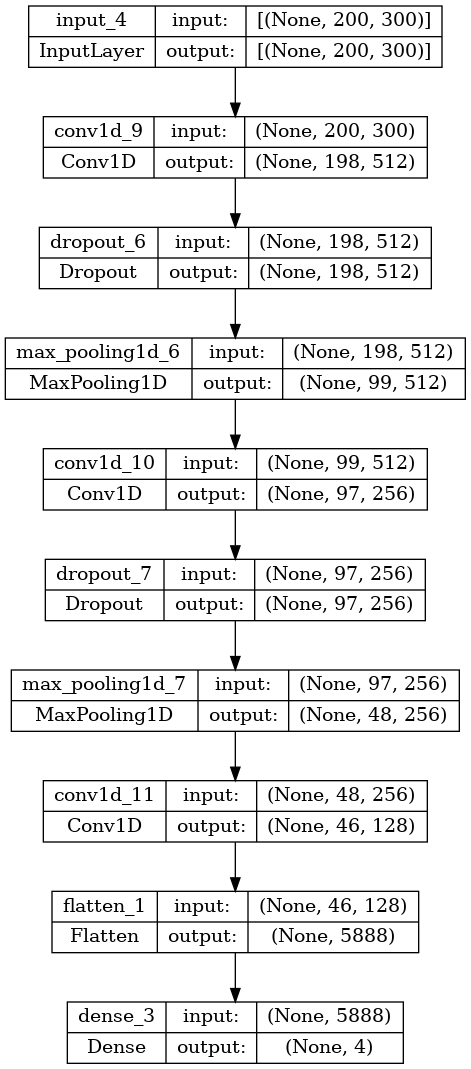

In [174]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [175]:
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=2)

Epoch 1/50
79/79 - 2s - loss: 0.2477 - accuracy: 0.9177 - val_loss: 0.1045 - val_accuracy: 0.9817 - 2s/epoch - 29ms/step
Epoch 2/50
79/79 - 1s - loss: 0.0465 - accuracy: 0.9898 - val_loss: 0.0761 - val_accuracy: 0.9865 - 1s/epoch - 16ms/step
Epoch 3/50
79/79 - 1s - loss: 0.0388 - accuracy: 0.9924 - val_loss: 0.0613 - val_accuracy: 0.9873 - 1s/epoch - 15ms/step
Epoch 4/50
79/79 - 1s - loss: 0.0336 - accuracy: 0.9930 - val_loss: 0.0706 - val_accuracy: 0.9865 - 1s/epoch - 15ms/step
Epoch 5/50
79/79 - 1s - loss: 0.0327 - accuracy: 0.9932 - val_loss: 0.0634 - val_accuracy: 0.9865 - 1s/epoch - 16ms/step
Epoch 6/50
79/79 - 1s - loss: 0.0348 - accuracy: 0.9932 - val_loss: 0.0561 - val_accuracy: 0.9873 - 1s/epoch - 17ms/step
Epoch 7/50
79/79 - 1s - loss: 0.0335 - accuracy: 0.9932 - val_loss: 0.0546 - val_accuracy: 0.9873 - 1s/epoch - 17ms/step
Epoch 8/50
79/79 - 1s - loss: 0.0339 - accuracy: 0.9932 - val_loss: 0.0502 - val_accuracy: 0.9889 - 1s/epoch - 16ms/step
Epoch 9/50
79/79 - 1s - loss: 0.

In [178]:
from matplotlib import pyplot as plt

def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

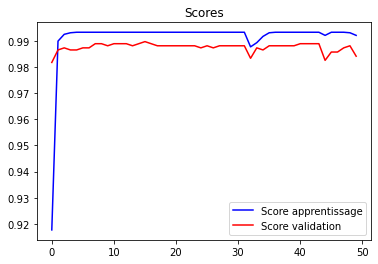

In [179]:
plot_scores(train)

## Tests

In [195]:
data_test = [
    'fram: jaysee chan ‘wayne 456, avenue % 90001 los angeles california unked states (us)',
    '7484874d4878145 721454',
    'Paul Michel 06825471 contact',
    '30 rue des maronniers, 59370, Mons, France',
    'sample mailer 1123 main st test city dc 20260 address',
    'ship date: 11/23/2000 weight: 1lbs 9 oz',
    'weight 15 lbs',
    'piece 1 of 1'
]

data = vectorization(data_test)

res = model.predict(data)

1/1 [==============================] - 0s 33ms/step


In [196]:
res

array([[1.0000000e+00, 0.0000000e+00, 5.9311223e-28, 0.0000000e+00],
       [1.8892084e-05, 9.7569782e-01, 1.4952325e-05, 2.4268407e-02],
       [2.9669097e-22, 2.3823302e-32, 1.0000000e+00, 6.6636543e-14],
       [1.0000000e+00, 0.0000000e+00, 2.9900501e-17, 6.3895308e-21],
       [1.0000000e+00, 0.0000000e+00, 5.1522199e-14, 1.2556128e-21],
       [4.7351866e-19, 3.5260091e-29, 2.4177861e-08, 1.0000000e+00],
       [1.6377665e-12, 1.7042628e-26, 1.6157864e-12, 1.0000000e+00],
       [9.6374508e-09, 2.6916058e-17, 3.1653842e-09, 1.0000000e+00]],
      dtype=float32)